# Effect of Land Cover on Pollution in Chesapeake Watershed
## Hack the Bay 2020

### Project by: Charlotte Ellison, Megan Maloney, and Joe Barrow

Our product uses a model trained on the land cover of upstream area of stations to allow a user to predict pollution given land cover parameters of their choosing.

Data:
-NCLD: https://www.mrlc.gov/

-Water Quality (CBP stations): https://github.com/Hack-the-Bay/hack-the-bay

Background information from: https://www.chesapeakebay.net/what/programs/monitoring

Template for some of the code: https://github.com/moezilla-ml/DatabricksHackathon

This code (1) looks at correlation between landcover types and polluation measures and (2) builds linear, random forest, adn gradient boosting regressor.

In [1]:
#load modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import math
import geopandas 

import seaborn as sns
import datetime as dt
import scipy.stats as stats
from io import StringIO

#models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

## Read In Data

We use Water Quality data from CBP stations from the data provided. We also use land cover data as the inputs of study in the data exploration and modeling. Three levels of Hydrologic Unit Codes (HUCs) are used to find the propotion of land cover types in the vicinity of a station. We used ArcGIS to find the proportion of each land cover type in the HUCS upstream from a station.

In [2]:
#read in data

#measurements data (with HUCS)
#NOTE- NEED TO UNZIP WateQuality_wHUC_Percents.zip to get WateQuality_wHUC_Percents.csv
file_location = 'WateQuality_wHUC_Percents.csv'
datadf = pd.read_csv(file_location)

#stream flow data
file_location = 'TrueLocationsStreamFlow.csv'
streamFlow = pd.read_csv(file_location)

#merge on locations
datadf = pd.merge(datadf, streamFlow, how = 'left', left_on = ['Latitude','Longitude'], right_on = ['Latitude','Longitude'])

datadf

,Unnamed: 0_x,Station,Latitude,Longitude,HUC12_,HUCNAME_,FIPS_,STATE_,COUNTY_,DateTime,...,PctVALUE_42,PctVALUE_43,PctVALUE_45,PctVALUE_46,PctVALUE_52,PctVALUE_71,PctVALUE_81,PctVALUE_82,PctVALUE_90,PctVALUE_95
0,0,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,10/12/2011 9:00,...,0.004476,0.022401,0.000532,0.000260,0.001840,0.000145,0.005814,0.512727,0.313008,0.000820
1,1,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,11/7/2011 11:00,...,0.004476,0.022401,0.000532,0.000260,0.001840,0.000145,0.005814,0.512727,0.313008,0.000820
2,2,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,12/1/2011 10:30,...,0.004476,0.022401,0.000532,0.000260,0.001840,0.000145,0.005814,0.512727,0.313008,0.000820
3,3,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,12/8/2011 11:30,...,0.004476,0.022401,0.000532,0.000260,0.001840,0.000145,0.005814,0.512727,0.313008,0.000820
4,4,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,1/9/2012 10:30,...,0.004476,0.022401,0.000532,0.000260,0.001840,0.000145,0.005814,0.512727,0.313008,0.000820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76889,77085,XEA3687,38.55925,-77.18870,20700110102,Marbury Run-Mattawoman Creek,24017,MD,Charles County,5/7/2008 9:00,...,0.055401,0.352383,0.008028,0.003815,0.003822,0.000301,0.018392,0.310838,0.068752,0.003987
76890,77086,XEA3687,38.55925,-77.18870,20700110102,Marbury Run-Mattawoman Creek,24017,MD,Charles County,5/21/2008 8:00,...,0.055401,0.352383,0.008028,0.003815,0.003822,0.000301,0.018392,0.310838,0.068752,0.003987
76891,77087,XEA3687,38.55925,-77.18870,20700110102,Marbury Run-Mattawoman Creek,24017,MD,Charles County,5/21/2008 13:22,...,0.055401,0.352383,0.008028,0.003815,0.003822,0.000301,0.018392,0.310838,0.068752,0.003987
76892,77088,XEA3687,38.55925,-77.18870,20700110102,Marbury Run-Mattawoman Creek,24017,MD,Charles County,6/4/2008 8:15,...,0.055401,0.352383,0.008028,0.003815,0.003822,0.000301,0.018392,0.310838,0.068752,0.003987


In [3]:
#remove null
#check for nulls
print(datadf.isnull().sum())

#remove 196 entries
datadf = datadf.dropna(subset=['PctVALUE_95'])
print(datadf.isnull().sum())

Unnamed: 0_x      0
Station           0
Latitude          0
Longitude         0
HUC12_            0
               ... 
PctVALUE_71     224
PctVALUE_81     224
PctVALUE_82     224
PctVALUE_90     224
PctVALUE_95     224
Length: 130, dtype: int64
Unnamed: 0_x    0
Station         0
Latitude        0
Longitude       0
HUC12_          0
               ..
PctVALUE_71     0
PctVALUE_81     0
PctVALUE_82     0
PctVALUE_90     0
PctVALUE_95     0
Length: 130, dtype: int64


In [4]:
datadf

,Unnamed: 0_x,Station,Latitude,Longitude,HUC12_,HUCNAME_,FIPS_,STATE_,COUNTY_,DateTime,...,PctVALUE_42,PctVALUE_43,PctVALUE_45,PctVALUE_46,PctVALUE_52,PctVALUE_71,PctVALUE_81,PctVALUE_82,PctVALUE_90,PctVALUE_95
0,0,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,10/12/2011 9:00,...,0.004476,0.022401,0.000532,0.000260,0.001840,0.000145,0.005814,0.512727,0.313008,0.000820
1,1,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,11/7/2011 11:00,...,0.004476,0.022401,0.000532,0.000260,0.001840,0.000145,0.005814,0.512727,0.313008,0.000820
2,2,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,12/1/2011 10:30,...,0.004476,0.022401,0.000532,0.000260,0.001840,0.000145,0.005814,0.512727,0.313008,0.000820
3,3,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,12/8/2011 11:30,...,0.004476,0.022401,0.000532,0.000260,0.001840,0.000145,0.005814,0.512727,0.313008,0.000820
4,4,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,1/9/2012 10:30,...,0.004476,0.022401,0.000532,0.000260,0.001840,0.000145,0.005814,0.512727,0.313008,0.000820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76889,77085,XEA3687,38.55925,-77.18870,20700110102,Marbury Run-Mattawoman Creek,24017,MD,Charles County,5/7/2008 9:00,...,0.055401,0.352383,0.008028,0.003815,0.003822,0.000301,0.018392,0.310838,0.068752,0.003987
76890,77086,XEA3687,38.55925,-77.18870,20700110102,Marbury Run-Mattawoman Creek,24017,MD,Charles County,5/21/2008 8:00,...,0.055401,0.352383,0.008028,0.003815,0.003822,0.000301,0.018392,0.310838,0.068752,0.003987
76891,77087,XEA3687,38.55925,-77.18870,20700110102,Marbury Run-Mattawoman Creek,24017,MD,Charles County,5/21/2008 13:22,...,0.055401,0.352383,0.008028,0.003815,0.003822,0.000301,0.018392,0.310838,0.068752,0.003987
76892,77088,XEA3687,38.55925,-77.18870,20700110102,Marbury Run-Mattawoman Creek,24017,MD,Charles County,6/4/2008 8:15,...,0.055401,0.352383,0.008028,0.003815,0.003822,0.000301,0.018392,0.310838,0.068752,0.003987


In [5]:
#look at column names
a  = datadf.columns
for i in range(0,len(a)):
    print(a[i])

Unnamed: 0_x
Station
Latitude
Longitude
HUC12_
HUCNAME_
FIPS_
STATE_
COUNTY_
DateTime
ACTIVE CHLOROPHYLL-A
DISSOLVED OXYGEN IN MG/L
AMMONIUM NITROGEN AS N (FILTERED SAMPLE)
NITRATE NITROGEN AS N (FILTERED SAMPLE)
PH CORRECTED FOR TEMPERATURE (25 DEG C)
ORTHOPHOSPHATE PHOSPHORUS AS P (FILTERED SAMPLE)
SALINITY UNITS IN PPT AND EQUAL TO PRACTICAL SALNITY UNITS (PSU)
SECCHI DEPTH
TOTAL ALKALINITY AS CACO3
TOTAL DISSOLVED SOLIDS; GRAVIMETRIC; DRIED AT 180 C
TOTAL KJELDAHL NITROGEN (WHOLE SAMPLE)
TOTAL NITROGEN
TOTAL PHOSPHORUS
TOTAL SUSPENDED SOLIDS
TURBIDITY; NEPHELOMETRIC METHOD
WATER TEMPERATURE DEG
HUC12
HUC10
HUC8
V_0_PERCENT
V_11_PERCENT
V_21_PERCENT
V_22_PERCENT
V_23_PERCENT
V_24_PERCENT
V_31_PERCENT
V_41_PERCENT
V_42_PERCENT
V_43_PERCENT
V_45_PERCENT
V_46_PERCENT
V_52_PERCENT
V_71_PERCENT
V_81_PERCENT
V_82_PERCENT
V_90_PERCENT
V_95_PERCENT
V_0_PERCENT_10
V_11_PERCENT_10
V_21_PERCENT_10
V_22_PERCENT_10
V_23_PERCENT_10
V_24_PERCENT_10
V_31_PERCENT_10
V_41_PERCENT_10
V_42_PERCENT_10
V

In [6]:
#names- HUC12, HUC10, HUC8, stream percents
HUC12_percent = ['V_11_PERCENT', 'V_21_PERCENT',
       'V_22_PERCENT', 'V_23_PERCENT', 'V_24_PERCENT', 'V_31_PERCENT',
       'V_41_PERCENT', 'V_42_PERCENT', 'V_43_PERCENT', 'V_45_PERCENT',
       'V_46_PERCENT', 'V_52_PERCENT', 'V_71_PERCENT', 'V_81_PERCENT',
       'V_82_PERCENT', 'V_90_PERCENT', 'V_95_PERCENT']


HUC10_percent = ['V_11_PERCENT_10', 'V_21_PERCENT_10', 'V_22_PERCENT_10',
       'V_23_PERCENT_10', 'V_24_PERCENT_10', 'V_31_PERCENT_10',
       'V_41_PERCENT_10', 'V_42_PERCENT_10', 'V_43_PERCENT_10',
       'V_45_PERCENT_10', 'V_46_PERCENT_10', 'V_52_PERCENT_10',
       'V_71_PERCENT_10', 'V_81_PERCENT_10', 'V_82_PERCENT_10',
       'V_90_PERCENT_10', 'V_95_PERCENT_10']

HUC8_percent = ['V_11_PERCENT_8','V_21_PERCENT_8', 'V_22_PERCENT_8', 'V_23_PERCENT_8', 'V_24_PERCENT_8',
       'V_31_PERCENT_8', 'V_41_PERCENT_8', 'V_42_PERCENT_8', 'V_43_PERCENT_8',
       'V_45_PERCENT_8', 'V_46_PERCENT_8', 'V_52_PERCENT_8', 'V_71_PERCENT_8',
       'V_81_PERCENT_8', 'V_82_PERCENT_8', 'V_90_PERCENT_8', 'V_95_PERCENT_8',]

stream_percent =['PctVALUE_11', 'PctVALUE_21', 'PctVALUE_22', 'PctVALUE_23',
       'PctVALUE_24', 'PctVALUE_31', 'PctVALUE_41', 'PctVALUE_42',
       'PctVALUE_43', 'PctVALUE_45', 'PctVALUE_46', 'PctVALUE_52',
       'PctVALUE_71', 'PctVALUE_81', 'PctVALUE_82', 'PctVALUE_90',
       'PctVALUE_95']

landcover_types = ['open water','developed, open space', 'developed low intensity',
                  'developed medium intensity', 'developed high intensity', 'barren land', 'deciduous forest',
                  'evergreen forest', 'mixed forest', 'shrub-Forest', 'herbaceous-Forest', 'shrub or scrub', 'grassland or herbaceous',
                   'pasture and hay', 'cultivated crops', 'woody wetland',
                  'emergent herbaceous wetland']

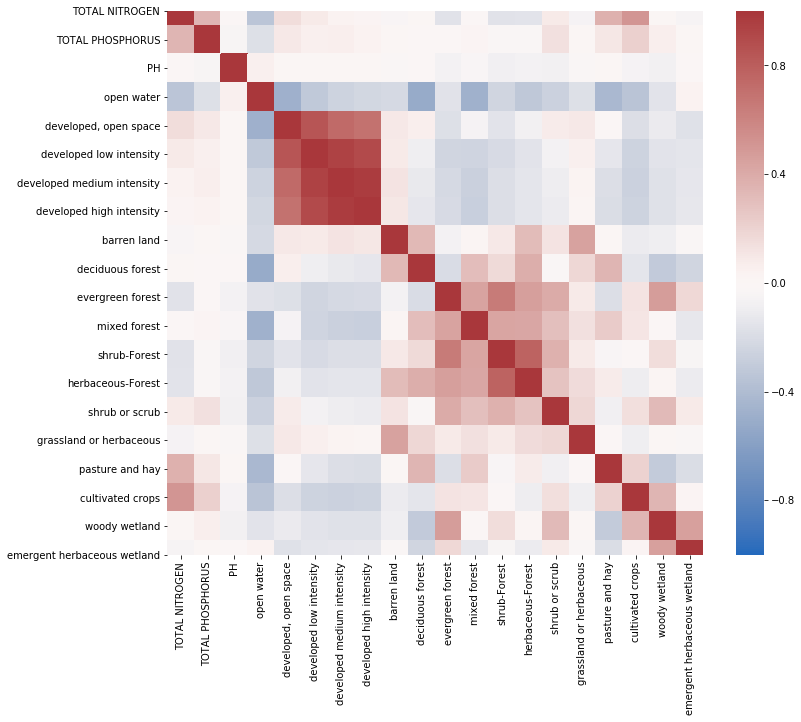

In [7]:
#correlation between Nitrogen and HUC12
outputs = ['TOTAL NITROGEN', 'TOTAL PHOSPHORUS','PH CORRECTED FOR TEMPERATURE (25 DEG C)' ]
curr_selection = outputs+HUC12_percent
curr = datadf[curr_selection]
corrHUCs = curr.corr(method ='pearson')
fig = plt.subplots(figsize=(12,10)) 
sns.heatmap(corrHUCs,cmap="vlag", vmin = -1, vmax = 1, xticklabels=['TOTAL NITROGEN', 'TOTAL PHOSPHORUS', 'PH']+landcover_types, yticklabels=['TOTAL NITROGEN', 'TOTAL PHOSPHORUS', 'PH']+landcover_types)

plt.savefig('correlationNitHUC12.jpg')

We see that the land cover types relating to development are correlated. Some of the forest types are also correlated. 

Developed open space, pature and hay, as well as cultivated crops are postively correlated with nitrogen levels. Open water and some of the forest types are negative correlated with nitrogen.

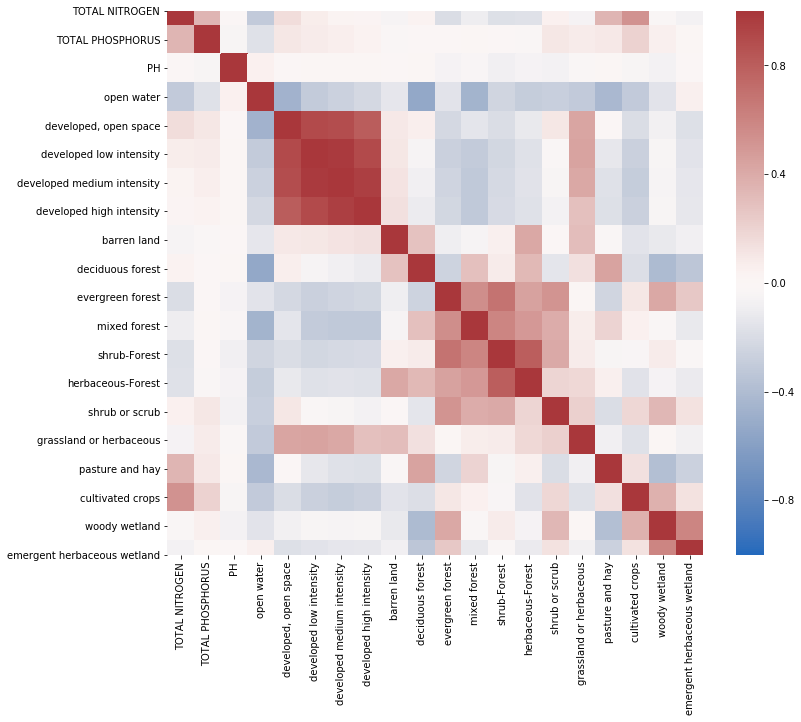

In [8]:
#HUC10 Correlation

outputs = ['TOTAL NITROGEN', 'TOTAL PHOSPHORUS','PH CORRECTED FOR TEMPERATURE (25 DEG C)' ]
curr_selection = outputs+HUC10_percent
curr = datadf[curr_selection]
corrHUCs = curr.corr(method ='pearson')
fig = plt.subplots(figsize=(12,10)) 
sns.heatmap(corrHUCs,cmap="vlag", vmin = -1, vmax = 1, xticklabels=['TOTAL NITROGEN', 'TOTAL PHOSPHORUS', 'PH']+landcover_types, yticklabels=['TOTAL NITROGEN', 'TOTAL PHOSPHORUS', 'PH']+landcover_types)

plt.savefig('correlationNitHUC10.jpg')

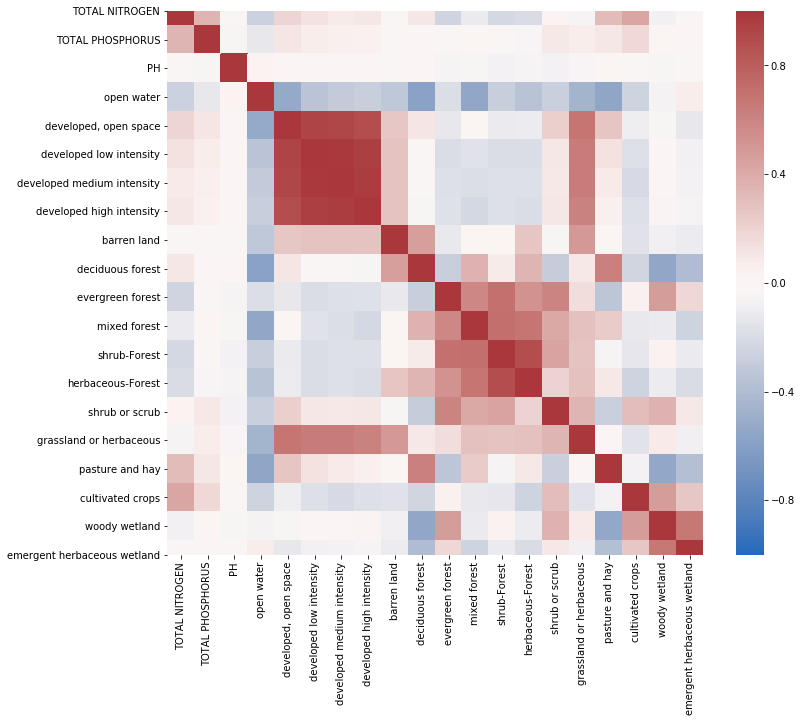

In [9]:
#HUC8 Correlation

outputs = ['TOTAL NITROGEN', 'TOTAL PHOSPHORUS','PH CORRECTED FOR TEMPERATURE (25 DEG C)' ]
curr_selection = outputs+HUC8_percent
curr = datadf[curr_selection]
corrHUCs = curr.corr(method ='pearson')
fig = plt.subplots(figsize=(12,10)) 
sns.heatmap(corrHUCs,cmap="vlag", vmin = -1, vmax = 1, xticklabels=['TOTAL NITROGEN', 'TOTAL PHOSPHORUS', 'PH']+landcover_types, yticklabels=['TOTAL NITROGEN', 'TOTAL PHOSPHORUS', 'PH']+landcover_types)

plt.savefig('correlationNitHUC8.jpg')

HUC8 is the largest HUC level we looked at. The development types are more highly correlated than in the smaller HUC levels, likely due to the larger area being covered within an individual unit.

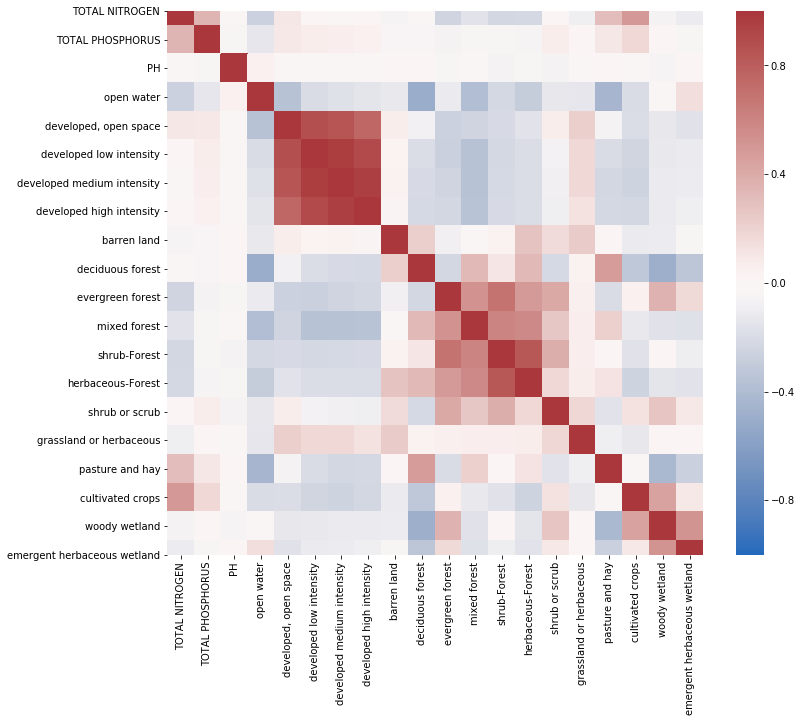

In [10]:
#correlation between pollution measures and Stream landcover

outputs = ['TOTAL NITROGEN', 'TOTAL PHOSPHORUS','PH CORRECTED FOR TEMPERATURE (25 DEG C)' ]
curr_selection = outputs+stream_percent
curr = datadf[curr_selection]
corrHUCs = curr.corr(method ='pearson')
fig = plt.subplots(figsize=(12,10)) 
sns.heatmap(corrHUCs,cmap="vlag", vmin = -1, vmax = 1, xticklabels=['TOTAL NITROGEN', 'TOTAL PHOSPHORUS', 'PH']+landcover_types, yticklabels=['TOTAL NITROGEN', 'TOTAL PHOSPHORUS', 'PH']+landcover_types)

plt.savefig('correlationNitHUCSream.jpg')

The upstream land cover type correlations are similar to the HUC land cover type correlations.

### Create Models

All models use a basic set of inputs (latitude, longitude, month, and year). We add different combinations of HUC8 land cover percentage, HUC10 land cover percentage, HUC12 land cover percentage, and upstream land cover percentage. We use linear, random forest, and gradient boosted regression. We train on all year up until and including 2015. We then test on years 2016 to present.

In [11]:
#We selected Nitrogen as the pollutant measure of interest

#select entries with Nitrogen
datadf = datadf.dropna(subset=['TOTAL NITROGEN'])

#get month and year
datadf['year'] = pd.DatetimeIndex(datadf['DateTime']).year
datadf['month'] = pd.DatetimeIndex(datadf['DateTime']).month



C:\Users\Charlotte\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Charlotte\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


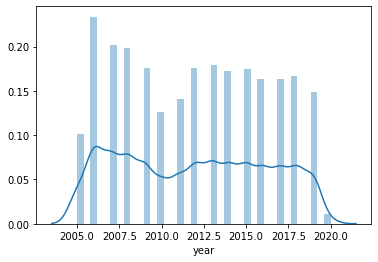

In [13]:
#display hitogram
sns.distplot(datadf['year'])

In [16]:
#run some (basic) models!!

#set train/test set
train = datadf[datadf['year']<=2015]
test = datadf[datadf['year']>2016]

In [17]:
test

,Unnamed: 0_x,Station,Latitude,Longitude,HUC12_,HUCNAME_,FIPS_,STATE_,COUNTY_,DateTime,...,PctVALUE_45,PctVALUE_46,PctVALUE_52,PctVALUE_71,PctVALUE_81,PctVALUE_82,PctVALUE_90,PctVALUE_95,year,month
102,102,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,1/4/2017 7:45,...,0.000532,0.00026,1.839589e-03,1.446220e-04,0.005814,0.512727,0.313008,0.000820,2017,1
103,103,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,1/24/2017 15:30,...,0.000532,0.00026,1.839589e-03,1.446220e-04,0.005814,0.512727,0.313008,0.000820,2017,1
104,104,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,2/6/2017 11:30,...,0.000532,0.00026,1.839589e-03,1.446220e-04,0.005814,0.512727,0.313008,0.000820,2017,2
105,105,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,3/2/2017 11:00,...,0.000532,0.00026,1.839589e-03,1.446220e-04,0.005814,0.512727,0.313008,0.000820,2017,3
106,106,1491000,38.99722,-75.78611,20600050203,Gravelly Branch-Choptank River,24011,MD,Caroline County,3/15/2017 9:00,...,0.000532,0.00026,1.839589e-03,1.446220e-04,0.005814,0.512727,0.313008,0.000820,2017,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83890,84086,XKH2555,39.54040,-76.07360,20600010000,Upper Chesapeake Bay,24015,MD,Cecil County,6/8/2017 9:00,...,0.000000,0.00000,4.585500e-07,4.585500e-07,0.000000,0.000000,0.000000,0.000055,2017,6
83891,84087,XKH2555,39.54040,-76.07360,20600010000,Upper Chesapeake Bay,24015,MD,Cecil County,7/17/2017 10:00,...,0.000000,0.00000,4.585500e-07,4.585500e-07,0.000000,0.000000,0.000000,0.000055,2017,7
83892,84088,XKH2555,39.54040,-76.07360,20600010000,Upper Chesapeake Bay,24015,MD,Cecil County,8/21/2017 13:00,...,0.000000,0.00000,4.585500e-07,4.585500e-07,0.000000,0.000000,0.000000,0.000055,2017,8
83893,84089,XKH2555,39.54040,-76.07360,20600010000,Upper Chesapeake Bay,24015,MD,Cecil County,9/27/2017 11:00,...,0.000000,0.00000,4.585500e-07,4.585500e-07,0.000000,0.000000,0.000000,0.000055,2017,9


In [18]:
#Linear
#include land cover info propotions pixels
depVar = ['Latitude', 'Longitude','month','year']
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = LinearRegression(normalize='True')
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('linear test',score_test)


depVar = ['Latitude', 'Longitude','month','year']+HUC12_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = LinearRegression(normalize='True')
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('linear, HUC12 test',score_test)

depVar = ['Latitude', 'Longitude','month','year']+HUC12_percent+HUC10_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = LinearRegression(normalize='True')
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('linear, HUC12 and HUC10 test',score_test)


depVar = ['Latitude', 'Longitude','month','year']+HUC12_percent+HUC10_percent+HUC8_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = LinearRegression(normalize='True')
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('linear, HUC12,HUC10, and HUC8, test',score_test)

depVar = ['Latitude', 'Longitude','month','year']+HUC12_percent+HUC10_percent+HUC8_percent+stream_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = LinearRegression(normalize='True')
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('linear, HUC12,HUC10, and HUC8, stream test',score_test)

depVar = ['Latitude', 'Longitude','month','year']+stream_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = LinearRegression(normalize='True')
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('linear, streampercent, test',score_test)

train 0.15874152071107572
linear test 0.15619171341514193
train 0.3708523401292606
linear, HUC12 test 0.4362775413420843
train 0.411983116530905
linear, HUC12 and HUC10 test 0.4869580241258067
train 0.4666210345318318
linear, HUC12,HUC10, and HUC8, test 0.5266963399396494
train 0.499662330579348
linear, HUC12,HUC10, and HUC8, stream test 0.5774864842396138
train 0.3813711657154705
linear, streampercent, test 0.4878368042886425


In [11]:
#Random Forest Regressor-need play around with params...
#include land cover info propotions pixels

depth = 5
max_feat = 'auto'

depVar = ['Latitude', 'Longitude','month','year']
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = RandomForestRegressor(max_depth = depth, max_features = max_feat)
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('random forest test',score_test)


depVar = ['Latitude', 'Longitude','month','year']+HUC12_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = RandomForestRegressor(max_depth = depth, max_features = max_feat)
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('random forest, HUC12 test',score_test)

depVar = ['Latitude', 'Longitude','month','year']+HUC12_percent+HUC10_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = RandomForestRegressor(max_depth = depth, max_features = max_feat)
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('random forest, HUC12 and HUC10 test',score_test)


depVar = ['Latitude', 'Longitude','month','year']+HUC12_percent+HUC10_percent+HUC8_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = RandomForestRegressor(max_depth = depth, max_features = max_feat)
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('random forest, HUC12,HUC10, and HUC8, test',score_test)

depVar = ['Latitude', 'Longitude','month','year']+HUC12_percent+HUC10_percent+HUC8_percent+stream_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = RandomForestRegressor(max_depth = depth, max_features = max_feat)
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('random forest, HUC12,HUC10, and HUC8, stream test',score_test)

depVar = ['Latitude', 'Longitude','month','year']+stream_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = RandomForestRegressor(max_depth = depth, max_features = max_feat)
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('random forest, stream, test',score_test)

C:\Users\Charlotte\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train 0.5516427363878353
random forest test 0.5753173360189785


C:\Users\Charlotte\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train 0.7054319504376143
random forest, HUC12 test 0.789127653070954


C:\Users\Charlotte\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train 0.7169182040315059
random forest, HUC12 and HUC10 test 0.7877465443788916


C:\Users\Charlotte\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train 0.7233362738578695
random forest, HUC12,HUC10, and HUC8, test 0.8011634987403717


C:\Users\Charlotte\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train 0.7127387952713795
random forest, HUC12,HUC10, and HUC8, stream test 0.7967990862682481


C:\Users\Charlotte\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train 0.6967067007910706
random forest, stream, test 0.7930930078663113


In [12]:
#gradient boosted trees



depVar = ['Latitude', 'Longitude','month','year']
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = GradientBoostingRegressor()
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('gradient boost test',score_test)


depVar = ['Latitude', 'Longitude','month','year']+HUC12_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = GradientBoostingRegressor()
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('gradient boost, HUC12 test',score_test)

depVar = ['Latitude', 'Longitude','month','year']+HUC12_percent+HUC10_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = GradientBoostingRegressor()
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('gradient boost, HUC12 and HUC10 test',score_test)


depVar = ['Latitude', 'Longitude','month','year']+HUC12_percent+HUC10_percent+HUC8_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = GradientBoostingRegressor()
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('gradient boost, HUC12,HUC10, and HUC8, test',score_test)


depVar = ['Latitude', 'Longitude','month','year']+HUC12_percent+HUC10_percent+HUC8_percent+stream_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = GradientBoostingRegressor()
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('gradient boost, HUC12,HUC10, and HUC8, stream test',score_test)

depVar = ['Latitude', 'Longitude','month','year']+stream_percent
X = train[depVar]
Y = train['TOTAL NITROGEN']

lr_tn = GradientBoostingRegressor()
lr_tn.fit(X,Y)
score_train = lr_tn.score(X, Y)
print('train', score_train)
score_test = lr_tn.score(test[depVar], test['TOTAL NITROGEN'])
print('gradient boost, stream, test',score_test)

train 0.6789867752351179
gradient boost test 0.7422131742724434
train 0.741682597834612
gradient boost, HUC12 test 0.805494787870166
train 0.7512599575269657
gradient boost, HUC12 and HUC10 test 0.8170502458222044
train 0.7512006093210393
gradient boost, HUC12,HUC10, and HUC8, test 0.8170622592799155
train 0.7601821096247998
gradient boost, HUC12,HUC10, and HUC8, stream test 0.8331409767300417
train 0.7423154936706132
gradient boost, stream, test 0.8265441016344903
